# LIME

## Computing saliency masks for LIME

Let's use the LIME  library:
```
pip install lime
```

In [1]:
# !pip install lime

In [1]:
# imports
import tensorflow as tf
import numpy as np
import PIL.Image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

from lime import lime_image

%matplotlib inline

In [2]:
print(f'Tensorflow verseion: {tf.__version__}')

Tensorflow verseion: 2.4.0


### Utility methods from the saliency example notebook

In [224]:
def LoadImage(file_path, model='VGG'):
    im = PIL.Image.open(file_path)
    if model == 'Inception':
        im = im.resize((299,299))
    else: 
        im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessVGGImage(im):
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im

def PreprocessInceptionImage(im):
    im = tf.keras.applications.inception_v3.preprocess_input(im)
    return im

## Examine superpixels

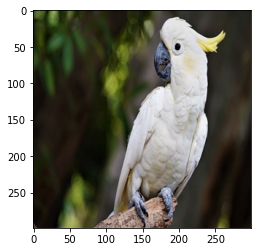

In [238]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='Inception')

plt.imshow(im_orig)
plt.show()

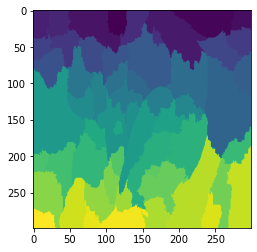

In [239]:
from skimage.segmentation import felzenszwalb, slic, quickshift

segments = quickshift(im_orig, kernel_size=4,
                      max_dist=200, ratio=0.2,
                      random_seed=42)
plt.imshow(segments)
plt.show()

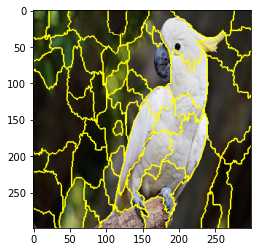

In [240]:
plt.imshow(mark_boundaries(im_orig, segments))
plt.show()

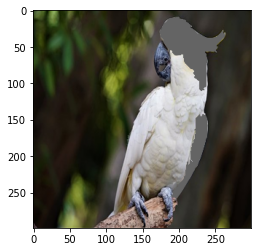

In [283]:
fudged_image = im_orig.copy()
# Isolate a few segments
fudged_image[segments == 11] = 100
fudged_image[segments == 28] = 100
fudged_image[segments == 16] = 100
fudged_image[segments == 55] = 100
fudged_image[segments == 56] = 100
plt.imshow(fudged_image)
plt.show()

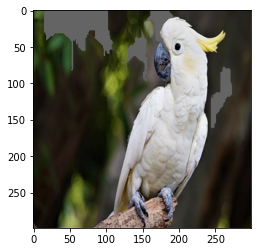

In [286]:
fudged_image = im_orig.copy()
# Isolate a few segments
fudged_image[segments == 1] = 100
fudged_image[segments == 2] = 100
fudged_image[segments == 18] = 100
fudged_image[segments == 5] = 100
fudged_image[segments == 36] = 100
plt.imshow(fudged_image)
plt.show()

The superpixel will be replaced by the average of its pixels.



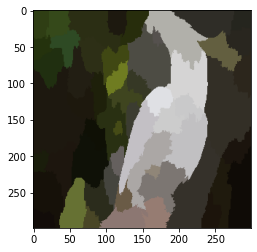

In [246]:
fudged_image = im_orig.copy()
# Replace superpixel with average of the pixel values
for x in np.unique(segments):
    fudged_image[segments == x] = (
        np.mean(im_orig[segments == x][:, 0]),
        np.mean(im_orig[segments == x][:, 1]),
        np.mean(im_orig[segments == x][:, 2]))
    
plt.imshow(fudged_image)
plt.show()

#### Using Felzenszwalb's algorithm

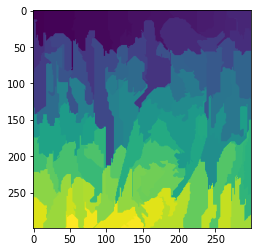

In [251]:
segments = felzenszwalb(im_orig, min_size=200)
plt.imshow(segments)
plt.show()

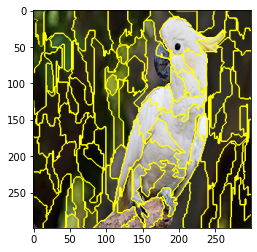

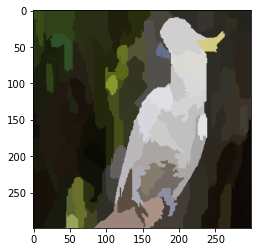

In [252]:
plt.imshow(mark_boundaries(im_orig, segments))
plt.show()
fudged_image = im_orig.copy()
for x in np.unique(segments):
    fudged_image[segments == x] = (
        np.mean(im_orig[segments == x][:, 0]),
        np.mean(im_orig[segments == x][:, 1]),
        np.mean(im_orig[segments == x][:, 2]))
plt.imshow(fudged_image)
plt.show()

## Explain predictions using LIME

### Using an Inception model

In [202]:
inception = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet')
model = tf.keras.models.Model(inception.inputs, inception.output)

Prediction class: 89


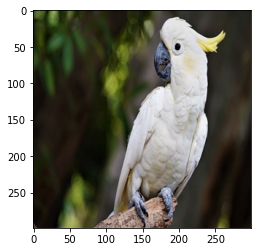

In [203]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='Inception')
image = PreprocessInceptionImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class)) 

In [179]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. 
Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'),
                                         inception.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


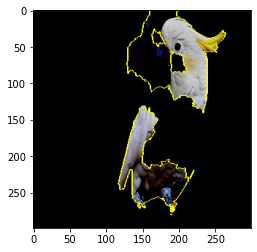

In [207]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True, num_features=6,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


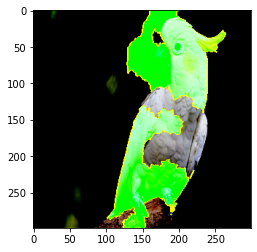

In [217]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


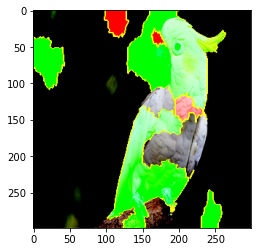

In [218]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

Compare with the explanations for the second highest prediction

In [209]:
explanation.top_labels[1]      # 129 indicates spoonbill

129

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


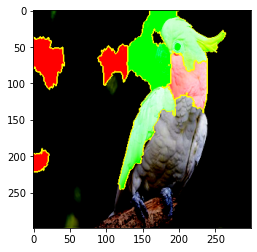

In [213]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False,
                                            num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

Next highest prediction, but seetting min_weight = 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


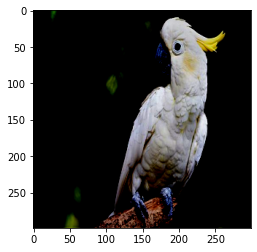

In [219]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, 
                                            num_features=100, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask))

Another example:

Prediction class: 11


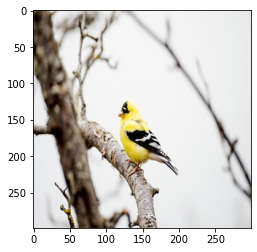

In [220]:
# Load the image
im_orig = LoadImage('./images/goldfinch.jpeg', model='Inception')
image = PreprocessInceptionImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))       # 11 corresponds to golfinch

In [221]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'),
                                         inception.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


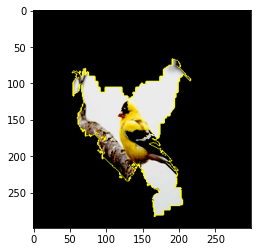

In [222]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True, num_features=5,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

### Using VGG-16 model

In [4]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', include_top=True)
model = tf.keras.models.Model(vgg16.inputs, vgg16.output)

Prediction class: 89


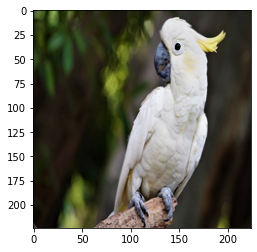

In [6]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='VGG')
image = PreprocessVGGImage(im_orig)

# Show the image
# ShowImage(im_orig)
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])
# call_model_args = {'class_idx_str': prediction_class}

print("Prediction class: " + str(prediction_class))  

In [7]:
explainer = lime_image.LimeImageExplainer()

In [25]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'),
                                         vgg16.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
from skimage.segmentation import mark_boundaries

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


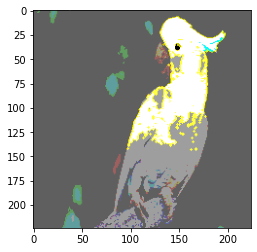

In [28]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(image, alpha=0.25)
plt.show()

### View pros and cons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


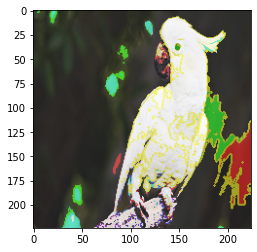

In [34]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)

Prediction class: 89


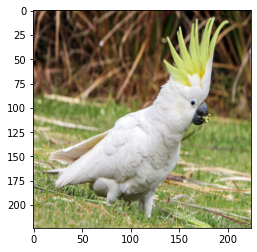

In [35]:
# Load the image
im_orig = LoadImage('./images/cockatoo_2.jpeg', model='VGG')
image = PreprocessVGGImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  

In [36]:
explainer = lime_image.LimeImageExplainer()

In [37]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'),
                                         vgg16.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


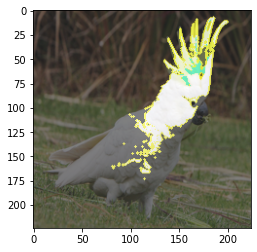

In [85]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp, mask), alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


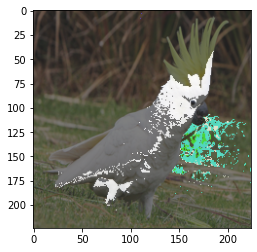

In [91]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=True, num_features=5, hide_rest=False, min_weight=0.5)
plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(im, mask), alpha=0.5)
plt.show()

### Explanation for the second highest prediction

The second highest predicion is "hen".

In [93]:
explanation.top_labels[1]

8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


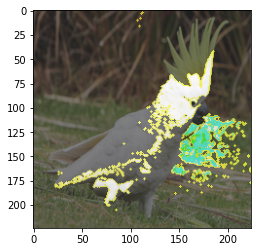

In [94]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp, mask), alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


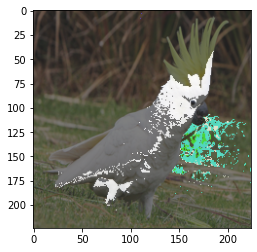

In [95]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=True, num_features=5, hide_rest=False, min_weight=0.5)
plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(im, mask), alpha=0.5)

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License